<a href="https://colab.research.google.com/github/Mehak-Shokeen/AeroVita/blob/main/AeroVita_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AEROVITA


### AI-Driven Respiratory risk and AQI Prediction Model

In [50]:
!pip install joblib seaborn


In [51]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import joblib


In [52]:
# Mount Google Drive to access shared dataset
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
file_path = "/content/drive/MyDrive/global_air_quality_data_10000.csv"
df = pd.read_csv(file_path)
df.head()

,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16


In [54]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   City         10000 non-null  object 
 1   Country      10000 non-null  object 
 2   Date         10000 non-null  object 
 3   PM2.5        10000 non-null  float64
 4   PM10         10000 non-null  float64
 5   NO2          10000 non-null  float64
 6   SO2          10000 non-null  float64
 7   CO           10000 non-null  float64
 8   O3           10000 non-null  float64
 9   Temperature  10000 non-null  float64
 10  Humidity     10000 non-null  float64
 11  Wind Speed   10000 non-null  float64
dtypes: float64(9), object(3)
memory usage: 937.6+ KB


,0
City,0
Country,0
Date,0
PM2.5,0
PM10,0
NO2,0
SO2,0
CO,0
O3,0
Temperature,0


In [55]:
df = df.dropna()
df.head()

,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16


In [56]:
def compute_aqi(row):
    pm25 = row['PM2.5']
    pm10 = row['PM10']
    no2  = row['NO2']
    so2  = row['SO2']
    o3   = row['O3']

    # ---- PM2.5 breakpoints ----
    def sub_index_pm25(x):
        if x <= 30: return (x/30)*50
        if x <= 60: return 50 + (x-30)*(50/30)
        if x <= 90: return 100 + (x-60)*(100/30)
        if x <= 120: return 200 + (x-90)*(100/30)
        if x <= 250: return 300 + (x-120)*(100/130)
        return 400 + (x-250)*(100/130)  # beyond severe

    # ---- PM10 breakpoints ----
    def sub_index_pm10(x):
        if x <= 50: return (x/50)*50
        if x <= 100: return 50 + (x-50)
        if x <= 250: return 100 + (x-100)*(100/150)
        if x <= 350: return 200 + (x-250)
        if x <= 430: return 300 + (x-350)*(100/80)
        return 400 + (x-430)*(100/80)

    # OTHER pollutants can be added similarly
    si_pm25 = sub_index_pm25(pm25)
    si_pm10 = sub_index_pm10(pm10)

    # FINAL AQI = max of all sub-indices
    return max(si_pm25, si_pm10)
df['AQI'] = df.apply(compute_aqi, axis=1)


In [57]:
df.columns

Index(['City', 'Country', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3',
       'Temperature', 'Humidity', 'Wind Speed', 'AQI'],
      dtype='object')

In [58]:
def asthma_risk(row):
    risk = 0

    # PM2.5 — strongest trigger
    if row['PM2.5'] > 120:
        risk += 2
    elif row['PM2.5'] > 80:
        risk += 1

    # PM10
    if row['PM10'] > 180:
        risk += 1

    # NO2 — respiratory irritant
    if row['NO2'] > 50:
        risk += 1

    # High humidity traps pollutants
    if row['Humidity'] > 70:
        risk += 1

    # Cold temperatures worsen asthma
    if row['Temperature'] < 20:
        risk += 1

    # Final decision
    if risk <= 2:
        return "Low"
    elif risk <= 4:
        return "Medium"
    else:
        return "High"
df['Asthma_Risk'] = df.apply(asthma_risk, axis=1)


In [59]:
def breathability(row):
    score = 100
    score -= row['PM2.5'] * 0.3
    score -= row['PM10'] * 0.1
    score -= row['NO2'] * 0.2
    score -= row['CO'] * 1.5

    if row['Humidity'] > 50:
        score -= (row['Humidity'] - 50) * 0.5

    score += row['Wind Speed'] * 0.3

    return min(100, max(0, score))

df['Breathability'] = df.apply(breathability, axis=1)


In [60]:
def outdoor_safe(row):
    if row['PM2.5'] > 120: return 0
    if row['PM10'] > 200: return 0
    if row['Humidity'] > 75 and row['PM2.5'] > 80: return 0
    if row['Wind Speed'] < 5 and row['PM2.5'] > 150: return 0
    return 1

df['Outdoor_Safe'] = df.apply(outdoor_safe, axis=1)


In [61]:
features = ['PM2.5','PM10','NO2','SO2','CO','O3','Temperature','Humidity','Wind Speed','AQI']
X = df[features]

y_asthma = df['Asthma_Risk']
y_breath = df['Breathability']
y_safe = df['Outdoor_Safe']


In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_a, y_test_a = train_test_split(X, y_asthma, test_size=0.2, random_state=42)
_, _, y_train_b, y_test_b = train_test_split(X, y_breath, test_size=0.2, random_state=42)
_, _, y_train_s, y_test_s = train_test_split(X, y_safe, test_size=0.2, random_state=42)


In [63]:
from sklearn.ensemble import RandomForestClassifier

clf_asthma = RandomForestClassifier()
clf_asthma.fit(X_train, y_train_a)


RandomForestClassifier()

In [64]:
from sklearn.ensemble import RandomForestRegressor

reg_breath = RandomForestRegressor()
reg_breath.fit(X_train, y_train_b)


RandomForestRegressor()

In [65]:
clf_safe = RandomForestClassifier()
clf_safe.fit(X_train, y_train_s)


RandomForestClassifier()

In [66]:
# TRAIN AQI MODEL — MUST be re-run after updating AQI values
X_aqi = df[['PM2.5','PM10','NO2','SO2','CO','O3']]
y_aqi = df['AQI']

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train_aqi, X_test_aqi, y_train_aqi, y_test_aqi = train_test_split(
    X_aqi, y_aqi, test_size=0.2, random_state=42
)

aqi_model = RandomForestRegressor()
aqi_model.fit(X_train_aqi, y_train_aqi)



RandomForestRegressor()

In [67]:
from sklearn.metrics import accuracy_score

pred_a = clf_asthma.predict(X_test)
print("Asthma Accuracy:", accuracy_score(y_test_a, pred_a))


Asthma Accuracy: 0.995


In [68]:
from sklearn.metrics import r2_score

pred_b = reg_breath.predict(X_test)
print("Breathability R²:", r2_score(y_test_b, pred_b))


Breathability R²: 0.9777245842781139


In [69]:
pred_s = clf_safe.predict(X_test)
print("Safety Accuracy:", accuracy_score(y_test_s, pred_s))


Safety Accuracy: 1.0


In [70]:
joblib.dump(clf_asthma, "asthma_model.pkl")


['asthma_model.pkl']

In [71]:
joblib.dump(reg_breath, "breath_model.pkl")


['breath_model.pkl']

In [72]:

joblib.dump(clf_safe, "safety_model.pkl")


['safety_model.pkl']

In [73]:

joblib.dump(aqi_model, "aqi_model.pkl")

['aqi_model.pkl']

In [74]:
import requests
import pandas as pd

def predict_live_delhi_waqi():
    token = "c37f9b9cefbdaa0c8eb6feeafb7b8441b0111b97"
    print("\nFetching LIVE Delhi Air Quality from WAQI...\n")

    # -----------------------------
    # 1. WAQI API (Reliable for Delhi)
    # -----------------------------
    waqi_url = f"https://api.waqi.info/feed/delhi/?token={token}"

    try:
        response = requests.get(waqi_url).json()
    except:
        print("❌ Cannot reach WAQI server.")
        return

    if response.get("status") != "ok":
        print("❌ WAQI Error:", response)
        return

    data = response["data"]
    iaqi = data.get("iaqi", {})

    pollutants = {
        "PM2.5": iaqi.get("pm25", {}).get("v"),
        "PM10": iaqi.get("pm10", {}).get("v"),
        "NO2": iaqi.get("no2", {}).get("v"),
        "SO2": iaqi.get("so2", {}).get("v"),
        "CO": iaqi.get("co", {}).get("v"),
        "O3": iaqi.get("o3", {}).get("v")
    }

    print("Pollutants:", pollutants)

    if pollutants["PM2.5"] is None:
        print("❌ Missing PM2.5 — cannot predict.")
        return

    # -----------------------------
    # 2. Weather (Open-Meteo)
    # -----------------------------
    weather_url = (
        "https://api.open-meteo.com/v1/forecast?"
        "latitude=28.6139&longitude=77.2090&"
        "current=temperature_2m,relative_humidity_2m,wind_speed_10m"
    )

    try:
        w = requests.get(weather_url).json()["current"]
        weather = {
            "Temperature": w.get("temperature_2m"),
            "Humidity": w.get("relative_humidity_2m"),
            "Wind Speed": w.get("wind_speed_10m")
        }
    except:
        print("❌ Weather fetch failed.")
        return

    print("Weather:", weather)

    # -----------------------------
    # 3. Prepare input for model
    # -----------------------------
    sample = pd.DataFrame([{
        "PM2.5": pollutants["PM2.5"],
        "PM10": pollutants["PM10"],
        "NO2": pollutants["NO2"],
        "SO2": pollutants["SO2"],
        "CO": pollutants["CO"],
        "O3": pollutants["O3"],
        "Temperature": weather["Temperature"],
        "Humidity": weather["Humidity"],
        "Wind Speed": weather["Wind Speed"],
        "AQI": compute_aqi({
            "PM2.5": pollutants["PM2.5"],
            "PM10": pollutants["PM10"],
            "NO2": pollutants["NO2"],
            "SO2": pollutants["SO2"],
            "O3": pollutants["O3"]
        })
    }])

    # -----------------------------
    # 4. Run ML Predictions
    # -----------------------------
    aqi_pred = aqi_model.predict(sample[['PM2.5','PM10','NO2','SO2','CO','O3']])[0]
    asthma_pred = clf_asthma.predict(sample)[0]
    breath_pred = reg_breath.predict(sample)[0]
    safety_pred = clf_safe.predict(sample)[0]

    print("\n----- ML Predictions for Selected Area -----")
    print("Predicted AQI:", round(aqi_pred, 2))
    print("Asthma Risk:", asthma_pred)
    print("Breathability Score:", round(breath_pred, 2))
    print("Outdoor Safety (1=safe,0=unsafe):", safety_pred)


In [75]:
predict_live_delhi_waqi()



Fetching LIVE Delhi Air Quality from WAQI...

Pollutants: {'PM2.5': 194, 'PM10': 184, 'NO2': 74.7, 'SO2': 10.6, 'CO': 14, 'O3': 3.3}
Weather: {'Temperature': 20.1, 'Humidity': 77, 'Wind Speed': 2.8}

----- ML Predictions for Selected Area -----
Predicted AQI: 323.01
Asthma Risk: High
Breathability Score: 4.47
Outdoor Safety (1=safe,0=unsafe): 0


In [76]:
!pip install IPython


In [77]:
import time
import requests
import matplotlib.pyplot as plt
from IPython.display import clear_output

token = "c37f9b9cefbdaa0c8eb6feeafb7b8441b0111b97"   # your token

def get_live_aqi():
    url = f"https://api.waqi.info/feed/delhi/?token={token}"
    try:
        response = requests.get(url).json()
        if response.get("status") == "ok":
            return response["data"]["aqi"]
        else:
            return None
    except:
        return None

def live_aqi_plot(duration_minutes=2, interval_seconds=10):
    """
    duration_minutes  = total minutes to record AQI
    interval_seconds  = time between each reading
    """
    readings = []
    timestamps = []

    total_points = int((duration_minutes * 60) / interval_seconds)

    print(f"📡 Collecting AQI for {duration_minutes} minutes...")
    print(f"⏱ One reading every {interval_seconds} seconds")
    print("🔁 Close the cell manually to stop early.\n")

    for i in range(total_points):
        clear_output(wait=True)
        aqi = get_live_aqi()

        if aqi is not None:
            readings.append(aqi)
            timestamps.append(i * interval_seconds)
        else:
            readings.append(None)
            timestamps.append(i * interval_seconds)

        # Plot
        plt.figure(figsize=(8,5))
        plt.plot(timestamps, readings, marker='o')
        plt.title("Live Delhi AQI Trend")
        plt.xlabel("Time (seconds)")
        plt.ylabel("AQI")
        plt.grid(True)
        plt.show()

        print(f"Latest AQI: {aqi}")
        print(f"Time: {i*interval_seconds} seconds")

        time.sleep(interval_seconds)

    print("\n✔ Data collection finished.")



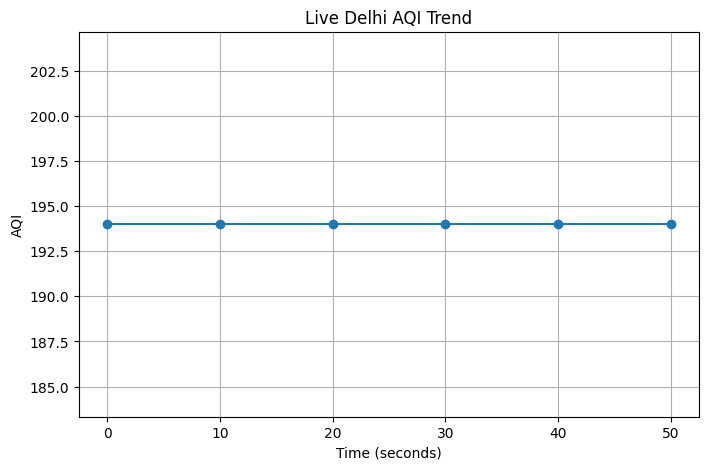

Latest AQI: 194
Time: 50 seconds

✔ Data collection finished.


In [78]:
live_aqi_plot(duration_minutes=1, interval_seconds=10)


In [79]:
df.head()

,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed,AQI,Asthma_Risk,Breathability,Outdoor_Safe
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76,188.566667,Medium,44.297,1
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36,97.390000,Low,53.497,1
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87,307.853846,Medium,39.194,0
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71,299.000000,Low,14.564,0
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16,92.000000,Medium,45.516,1


In [80]:
scoring_table = pd.DataFrame([
    {"Pollutant": "PM2.5", "Range (µg/m³)": "0-30", "Score": 0, "Severity": "Good"},
    {"Pollutant": "PM2.5", "Range (µg/m³)": "31-60", "Score": 1, "Severity": "Satisfactory"},
    {"Pollutant": "PM2.5", "Range (µg/m³)": "61-90", "Score": 2, "Severity": "Moderate"},
    {"Pollutant": "PM2.5", "Range (µg/m³)": "91-120", "Score": 3, "Severity": "Poor"},
    {"Pollutant": "PM2.5", "Range (µg/m³)": "121-250", "Score": 4, "Severity": "Very Poor"},
    {"Pollutant": "PM2.5", "Range (µg/m³)": "251+", "Score": 5, "Severity": "Severe"},
    {"Pollutant": "PM10", "Range (µg/m³)": "0-50", "Score": 0, "Severity": "Good"},
    {"Pollutant": "PM10", "Range (µg/m³)": "51-100", "Score": 1, "Severity": "Satisfactory"},
    {"Pollutant": "PM10", "Range (µg/m³)": "101-250", "Score": 2, "Severity": "Moderate"},
    {"Pollutant": "PM10", "Range (µg/m³)": "251-350", "Score": 3, "Severity": "Poor"},
    {"Pollutant": "PM10", "Range (µg/m³)": "351-430", "Score": 4, "Severity": "Very Poor"},
    {"Pollutant": "PM10", "Range (µg/m³)": "431+", "Score": 5, "Severity": "Severe"},
    {"Pollutant": "NO2", "Range (µg/m³)": "0-40", "Score": 0, "Severity": "Good"},
    {"Pollutant": "NO2", "Range (µg/m³)": "41-80", "Score": 1, "Severity": "Satisfactory"},
    {"Pollutant": "NO2", "Range (µg/m³)": "81-180", "Score": 2, "Severity": "Moderate"},
    {"Pollutant": "NO2", "Range (µg/m³)": "181+", "Score": 4, "Severity": "High"},
    {"Pollutant": "SO2", "Range (µg/m³)": "0-40", "Score": 0, "Severity": "Good"},
    {"Pollutant": "CO", "Range (mg/m³)": "0-2", "Score": 0, "Severity": "Good"},
    {"Pollutant": "O3", "Range (µg/m³)": "0-50", "Score": 0, "Severity": "Good"},
], columns=["Pollutant","Range (µg/m³)","Score","Severity"])

print("---- Medical Scoring Table (excerpt) ----")
display(scoring_table.head(20))


---- Medical Scoring Table (excerpt) ----


,Pollutant,Range (µg/m³),Score,Severity
0,PM2.5,0-30,0,Good
1,PM2.5,31-60,1,Satisfactory
2,PM2.5,61-90,2,Moderate
3,PM2.5,91-120,3,Poor
4,PM2.5,121-250,4,Very Poor
5,PM2.5,251+,5,Severe
6,PM10,0-50,0,Good
7,PM10,51-100,1,Satisfactory
8,PM10,101-250,2,Moderate
9,PM10,251-350,3,Poor


In [81]:
def medical_score_row(r):
    score = 0
    # PM2.5
    if r['PM2.5'] <= 30: score += 0
    elif r['PM2.5'] <= 60: score += 1
    elif r['PM2.5'] <= 90: score += 2
    elif r['PM2.5'] <= 120: score += 3
    elif r['PM2.5'] <= 250: score += 4
    else: score += 5
    # PM10
    if r['PM10'] <= 50: score += 0
    elif r['PM10'] <= 100: score += 1
    elif r['PM10'] <= 250: score += 2
    elif r['PM10'] <= 350: score += 3
    elif r['PM10'] <= 430: score += 4
    else: score += 5
    # NO2 (simple)
    if r['NO2'] <= 40: score += 0
    elif r['NO2'] <= 80: score += 1
    elif r['NO2'] <= 180: score += 2
    else: score += 4
    # Humidity penalty (high humidity increases risk)
    if r['Humidity'] > 70: score += 1
    # Temperature penalty (cold)
    if r['Temperature'] < 20: score += 1
    return score

if 'Medical_Score' not in df.columns:
    df['Medical_Score'] = df.apply(medical_score_row, axis=1)

In [82]:
def medscore_to_label(s):
    if s <= 2: return "Low"
    if s <= 5: return "Medium"
    return "High"

df['Medical_Risk'] = df['Medical_Score'].apply(medscore_to_label)

In [83]:
df.head()

,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed,AQI,Asthma_Risk,Breathability,Outdoor_Safe,Medical_Score,Medical_Risk
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76,188.566667,Medium,44.297,1,5,Medium
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36,97.390000,Low,53.497,1,4,Medium
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87,307.853846,Medium,39.194,0,7,High
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71,299.000000,Low,14.564,0,6,High
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16,92.000000,Medium,45.516,1,4,Medium


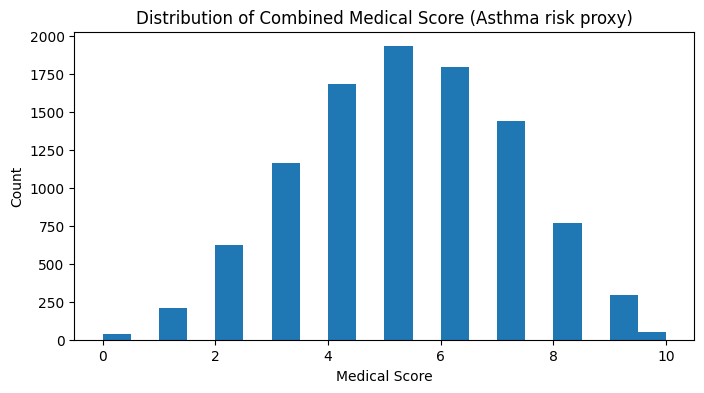

In [84]:
plt.figure(figsize=(8,4))
plt.hist(df['Medical_Score'].dropna(), bins=20)
plt.title("Distribution of Combined Medical Score (Asthma risk proxy)")
plt.xlabel("Medical Score")
plt.ylabel("Count")
plt.show()

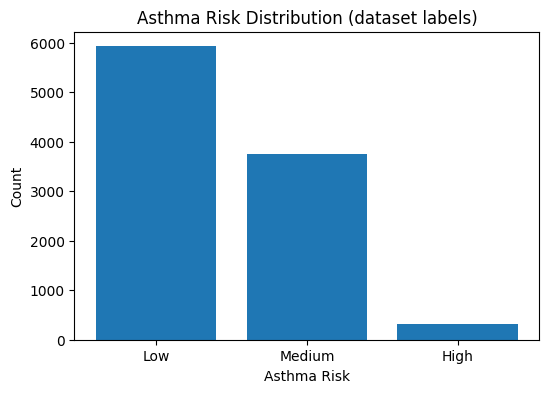

In [85]:
counts = df['Asthma_Risk'].value_counts().reindex(['Low','Medium','High']).fillna(0)
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values)
plt.title("Asthma Risk Distribution (dataset labels)")
plt.xlabel("Asthma Risk")
plt.ylabel("Count")
plt.show()

/tmp/ipython-input-2755217201.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group = df.groupby('AQI_bucket')['Asthma_Risk'].value_counts(normalize=True).unstack(fill_value=0)


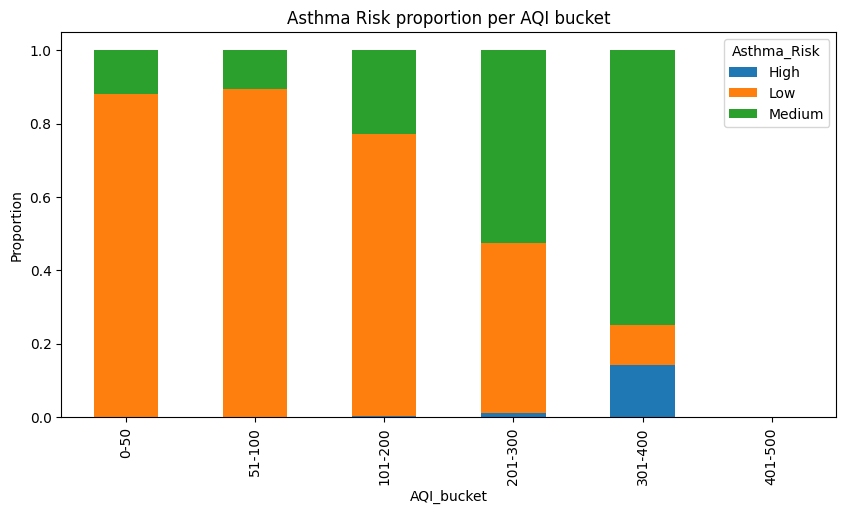

In [86]:
df['AQI_bucket'] = pd.cut(df['AQI'], bins=[0,50,100,200,300,400,500], labels=['0-50','51-100','101-200','201-300','301-400','401-500'])
group = df.groupby('AQI_bucket')['Asthma_Risk'].value_counts(normalize=True).unstack(fill_value=0)
group.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Asthma Risk proportion per AQI bucket")
plt.ylabel("Proportion")
plt.show()

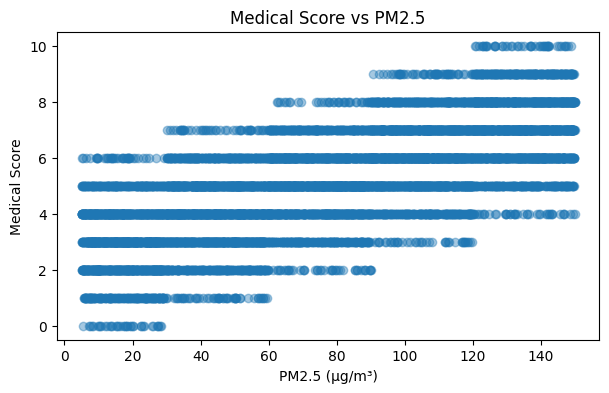

In [87]:
plt.figure(figsize=(7,4))
plt.scatter(df['PM2.5'], df['Medical_Score'], alpha=0.4)
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Medical Score")
plt.title("Medical Score vs PM2.5")
plt.show()

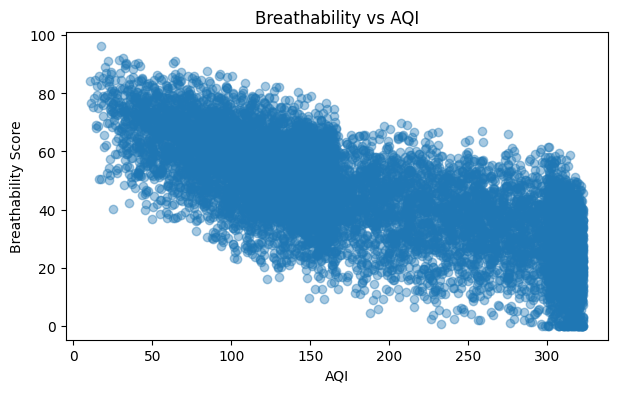

In [88]:
plt.figure(figsize=(7,4))
plt.scatter(df['AQI'], df['Breathability'], alpha=0.4)
plt.xlabel("AQI")
plt.ylabel("Breathability Score")
plt.title("Breathability vs AQI")
plt.show()


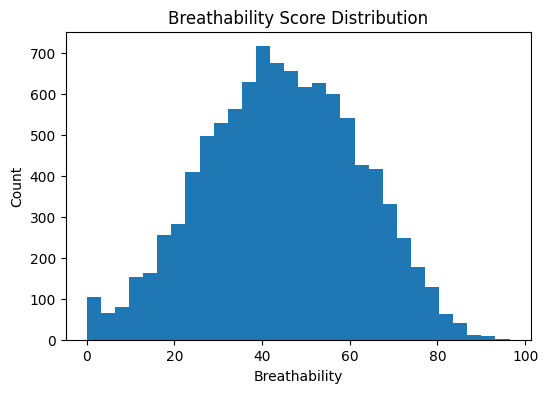

In [89]:
plt.figure(figsize=(6,4))
plt.hist(df['Breathability'].dropna(), bins=30)
plt.title("Breathability Score Distribution")
plt.xlabel("Breathability")
plt.ylabel("Count")
plt.show()

In [90]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


========== ASTHMA RISK MODEL ACCURACY ==========

Accuracy: 0.999
              precision    recall  f1-score   support

        High       1.00      0.98      0.99       315
         Low       1.00      1.00      1.00      5926
      Medium       1.00      1.00      1.00      3759

    accuracy                           1.00     10000
   macro avg       1.00      0.99      1.00     10000
weighted avg       1.00      1.00      1.00     10000



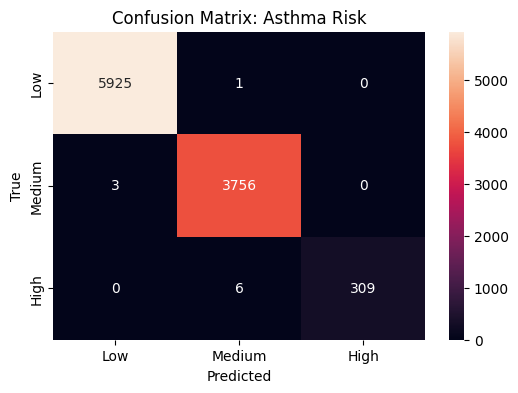


========== OUTDOOR SAFETY MODEL ACCURACY ==========

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2824
           1       1.00      1.00      1.00      7176

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



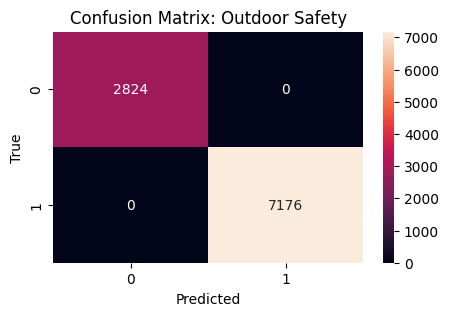


========== BREATHABILITY REGRESSION METRICS ==========

MAE: 1.057336204
RMSE: 1.4940936139880994
R² Score: 0.9927993139056438

========== AQI REGRESSION MODEL METRICS ==========

MAE: 0.035711199487178734
RMSE: 0.10964407196354335
R² Score: 0.9999984691713008


In [91]:
X_all = df[['PM2.5','PM10','NO2','SO2','CO','O3','Temperature','Humidity','Wind Speed','AQI']]

# ========================================================
# 1) ASTHMA RISK (Classification)
# ========================================================
y_true_a = df['Asthma_Risk']
y_pred_a = clf_asthma.predict(X_all)

print("========== ASTHMA RISK MODEL ACCURACY ==========\n")
print("Accuracy:", accuracy_score(y_true_a, y_pred_a))
print(classification_report(y_true_a, y_pred_a))

cm_asthma = confusion_matrix(y_true_a, y_pred_a, labels=["Low","Medium","High"])
plt.figure(figsize=(6,4))
sns.heatmap(cm_asthma, annot=True, fmt='d',
            xticklabels=["Low","Medium","High"],
            yticklabels=["Low","Medium","High"])
plt.title("Confusion Matrix: Asthma Risk")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ========================================================
# 2) OUTDOOR SAFETY (Classification)
# ========================================================
y_true_s = df['Outdoor_Safe']
y_pred_s = clf_safe.predict(X_all)

print("\n========== OUTDOOR SAFETY MODEL ACCURACY ==========\n")
print("Accuracy:", accuracy_score(y_true_s, y_pred_s))
print(classification_report(y_true_s, y_pred_s))

cm_safe = confusion_matrix(y_true_s, y_pred_s)
plt.figure(figsize=(5,3))
sns.heatmap(cm_safe, annot=True, fmt='d',
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix: Outdoor Safety")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ========================================================
# 3) BREATHABILITY (Regression)
# ========================================================
mae_b = mean_absolute_error(y_true_b, y_pred_b)
rmse_b = mean_squared_error(y_true_b, y_pred_b) ** 0.5
r2_b = r2_score(y_true_b, y_pred_b)

print("\n========== BREATHABILITY REGRESSION METRICS ==========\n")
print("MAE:", mae_b)
print("RMSE:", rmse_b)
print("R² Score:", r2_b)

# ========================================================
# 4) AQI MODEL (Regression)
# ========================================================
mae_q = mean_absolute_error(y_true_q, y_pred_q)
rmse_q = mean_squared_error(y_true_q, y_pred_q) ** 0.5
r2_q = r2_score(y_true_q, y_pred_q)

print("\n========== AQI REGRESSION MODEL METRICS ==========\n")
print("MAE:", mae_q)
print("RMSE:", rmse_q)
print("R² Score:", r2_q)

